In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import matplotlib.pyplot as plt
from src.experiments.plot_utils import *
from collections import defaultdict
from scipy.stats import ttest_ind

In [3]:
PLOT_DIR = "../experiments/plots"

BASE_DIR = "/Users/yavuz/scalable-multimodal-similarity-search/experiments/"
CONSTRUCTION_DIR = BASE_DIR + "construction/"
SEARCH_DIR = BASE_DIR + "search/"
EXACT_RESULTS_FOLDER = BASE_DIR + "exact_results/"
SAVED_INDEX_DIR = BASE_DIR + "saved_index/"
STATS_BASE_FOLDER = BASE_DIR + "stats-experiments/"


RERANK_CONSTRUCTION_DIR = BASE_DIR + "rerank_construction/"
RERANK_SEARCH_DIR = BASE_DIR + "rerank_search/"

SEARCH_WEIGHTS_DIR = BASE_DIR + "search_weights_exps/"
STATS_SEARCH_EXPS_FOLDER = STATS_BASE_FOLDER + "search_weights_exps/"

FIGURE_DPI = 200

In [4]:
import scienceplots
plt.style.use([ 'science']) # 'notebook' 'science'
plt.rcParams.update({'font.size': 14})

In [5]:
def plot_heatmap_for_search_weights_data(params, construction_params, search_weights_data, max_ef=float('inf'), plots_dir=PLOT_DIR, plot_index_line=True):
    # search_weights_data is weights -> ef -> list of recall for 100 queries
    # we have 11 values for weights: 0.0 to 1.0, and around 15 for ef
    # for each cell combination, we plot a heatmap of the average of the recall values

    # we plot image weights, so first transform to 1-text_weight
    transformed_data = {}
    for weight, ef_dict in search_weights_data.items():
        new_weight = round(1.0 - weight, 5)
        transformed_data[new_weight] = ef_dict
    weights = sorted(transformed_data.keys())
    efs = sorted({ef for ef_dict in transformed_data.values() for ef in ef_dict if ef <= max_ef})

    heatmap_data = np.zeros((len(weights), len(efs)))

    for i, weight in enumerate(weights):
        for j, ef in enumerate(efs):
            recall_list = transformed_data[weight][ef]
            assert len(recall_list) > 0, f"Missing data for weight {weight} and ef {ef}"
            heatmap_data[i, j] = np.mean(recall_list)

    plt.figure(figsize=(10, 6))
    im = plt.imshow(heatmap_data, aspect='auto', origin='lower', cmap='viridis', vmin=0.3, vmax=1) #viridis, YlGn, summer

    plt.xticks(ticks=np.arange(len(efs)), labels=efs)
    plt.yticks(ticks=np.arange(len(weights)), labels=[f"{w:.1f}" for w in weights])

    plt.xlabel("efSearch")
    plt.ylabel("Image Search Weight (1 - Text Search Weight)")
    plt.title(f"Recall Heatmap with Index Weights [{round(params.weights[0], 5)}, {round(params.weights[1], 5)}]")

    plt.colorbar(im, label="Average Recall")

    # plot a dotted line at index image weight
    if plot_index_line:
        y_pos = weights.index(params.weights[1])
        plt.axhline(y=y_pos, color='red', linestyle=':', linewidth=2, label=f'Index Image Weight')
        plt.legend(loc='upper right')  # Add legend to show the label

    plt.tight_layout()

    # save plot
    if not os.path.exists(f"{plots_dir}/search_weights"):
        os.makedirs(f"{plots_dir}/search_weights")
    print(params.weights[0],int(params.weights[0]*100))
    plt.savefig(f"{plots_dir}/search_weights/recall_heatmap_{params.index_size}_{params.metrics[0]}_{params.metrics[1]}_weight_{int(params.weights[0]*100)}_ef{construction_params.ef_construction}_seed_{construction_params.seed}_k{params.k}.pdf", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

In [6]:
search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=100_000)
search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)

prev_experiment_folder = 1
search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, SEARCH_WEIGHTS_DIR, prev_experiment_folder=prev_experiment_folder, bracket_split_char=":")
search_weights_exp_params.k = k

Loaded index-2025-04-10_04-44-12-585
Read values for k=50 for dataset size 100000 for 26 ef values


0.5 50


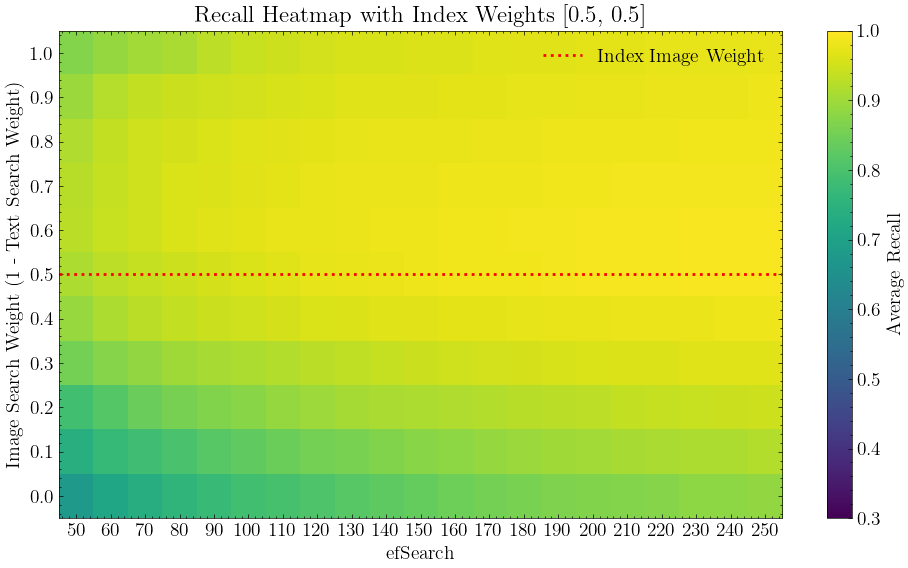

In [49]:
plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

In [17]:
search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=1_000_000)
search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)

prev_experiment_folder = 1
search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, SEARCH_WEIGHTS_DIR, prev_experiment_folder=prev_experiment_folder, bracket_split_char=":")
search_weights_exp_params.k = k

Read values for k=50 for dataset size 1000000 for 36 ef values


0.5 50


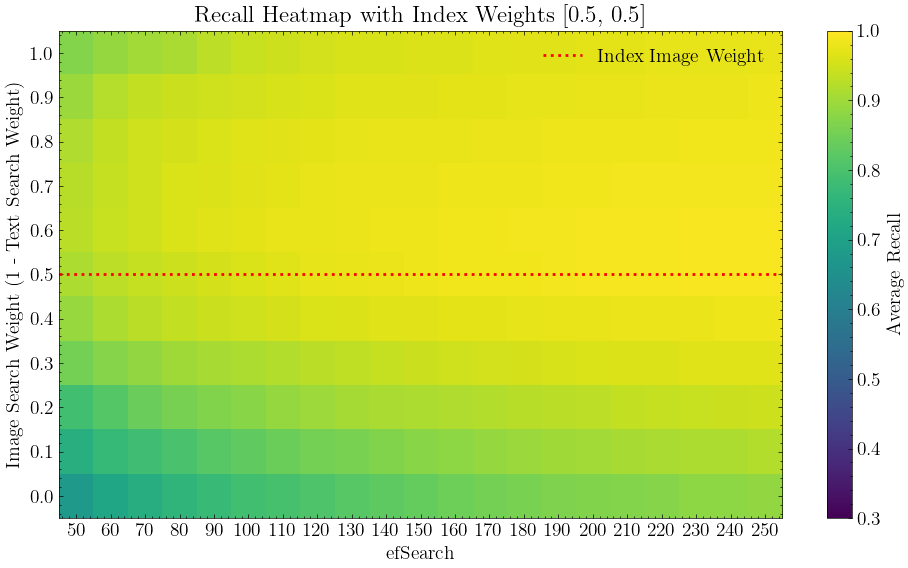

In [50]:
plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

Loaded index-2025-04-16_02-41-44-130
Read values for k=50 for dataset size 1000000 for 36 ef values
0.0 0


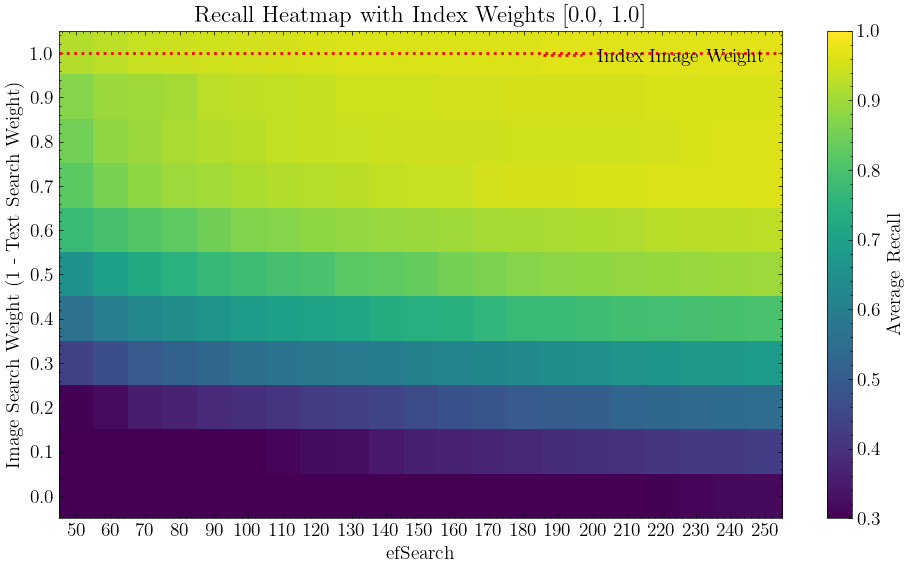

Loaded index-2025-04-16_02-55-03-000
Read values for k=50 for dataset size 1000000 for 36 ef values
0.1 10


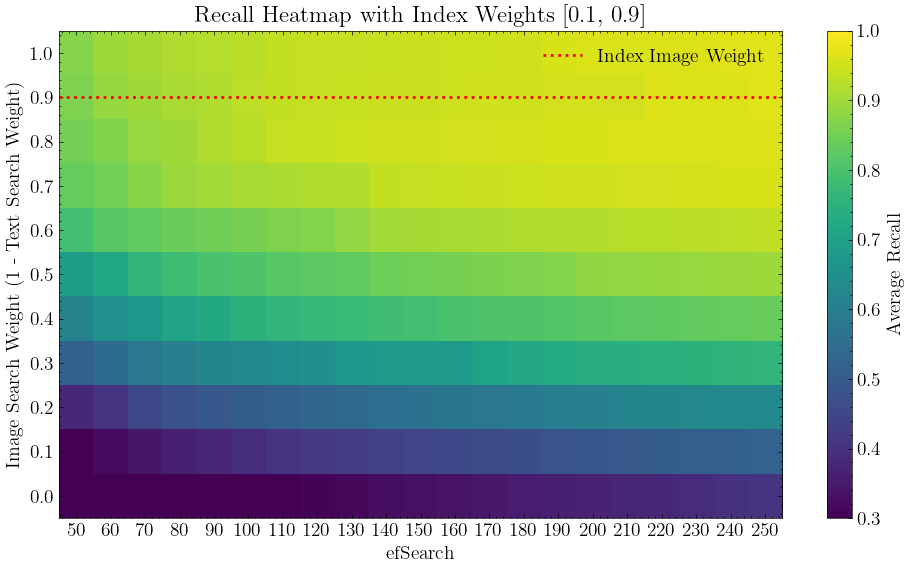

Loaded index-2025-04-16_03-10-18-738
Read values for k=50 for dataset size 1000000 for 36 ef values
0.2 20


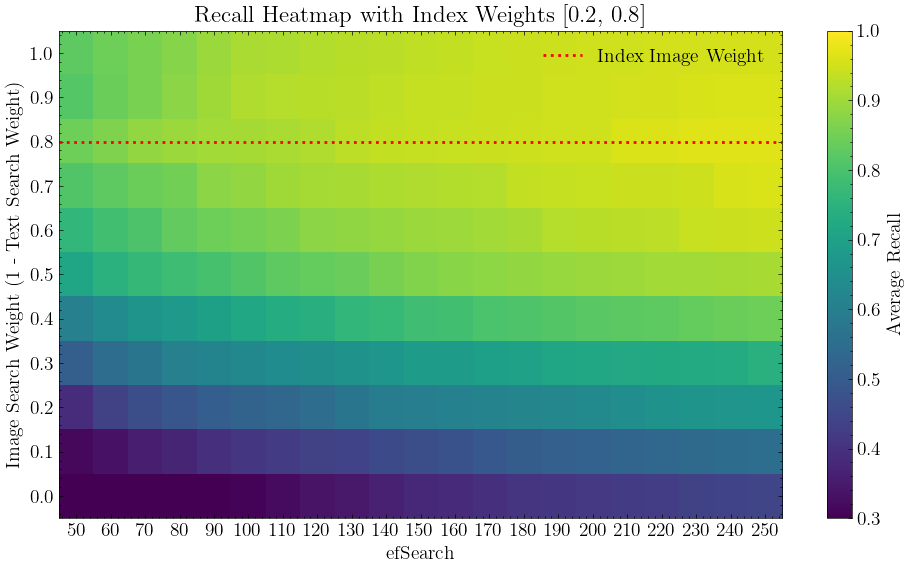

Loaded index-2025-04-16_03-27-04-400
Read values for k=50 for dataset size 1000000 for 36 ef values
0.3 30


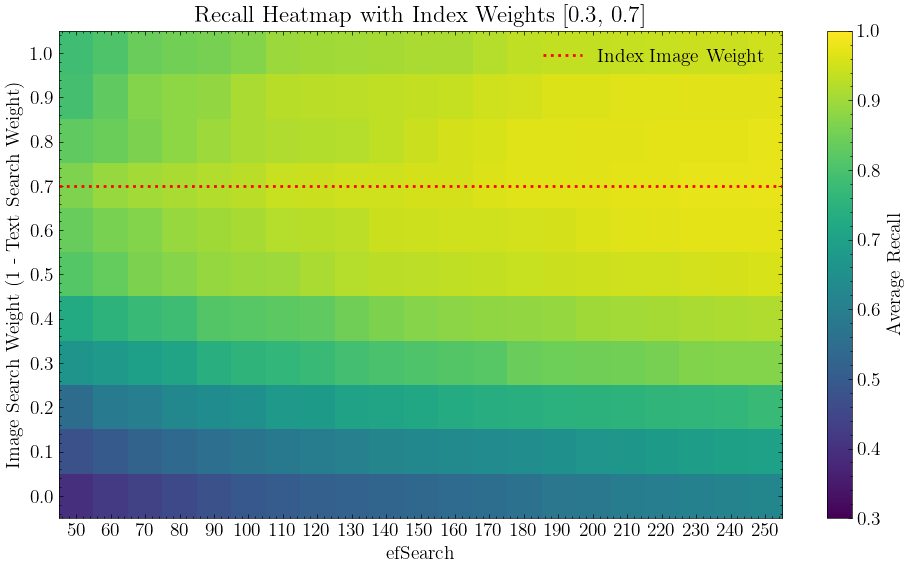

Loaded index-2025-04-16_03-44-51-645
Read values for k=50 for dataset size 1000000 for 36 ef values
0.4 40


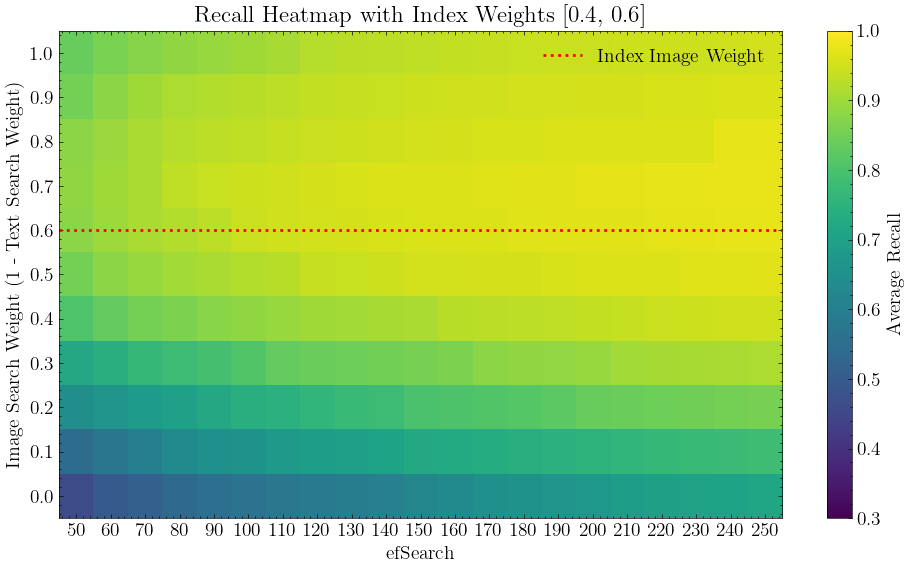

Loaded index-2025-04-16_04-03-26-685
Read values for k=50 for dataset size 1000000 for 36 ef values
0.5 50


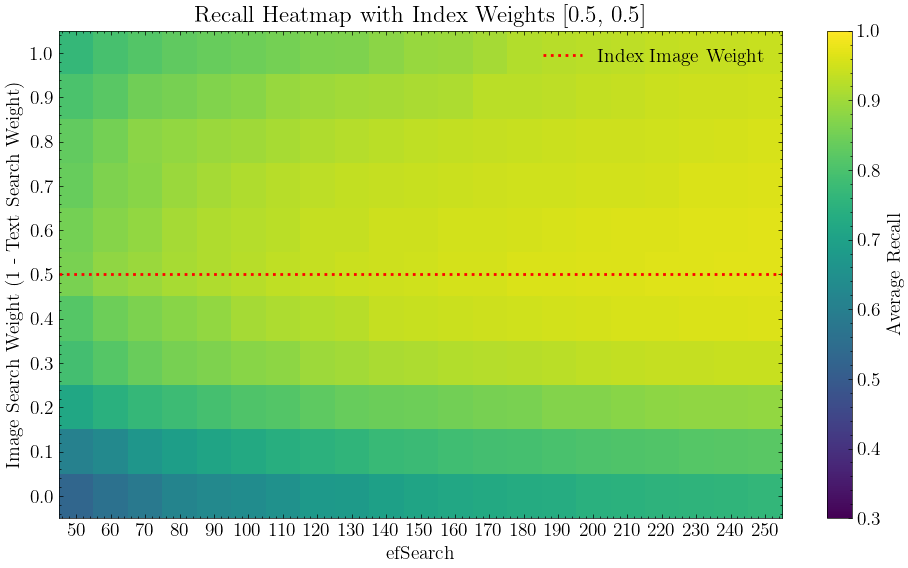

Loaded index-2025-04-16_04-23-15-171
Read values for k=50 for dataset size 1000000 for 36 ef values
0.6 60


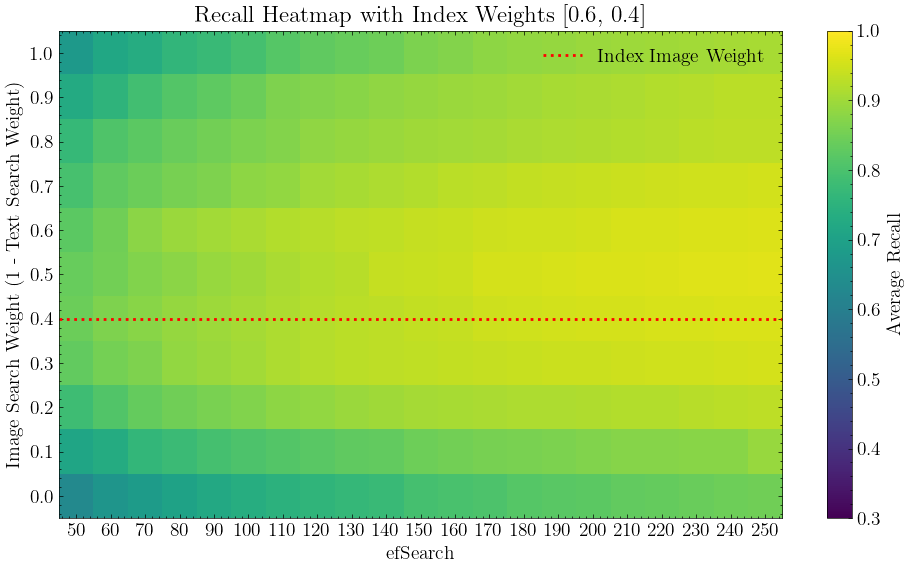

Loaded index-2025-04-16_04-43-37-361
Read values for k=50 for dataset size 1000000 for 36 ef values
0.7 70


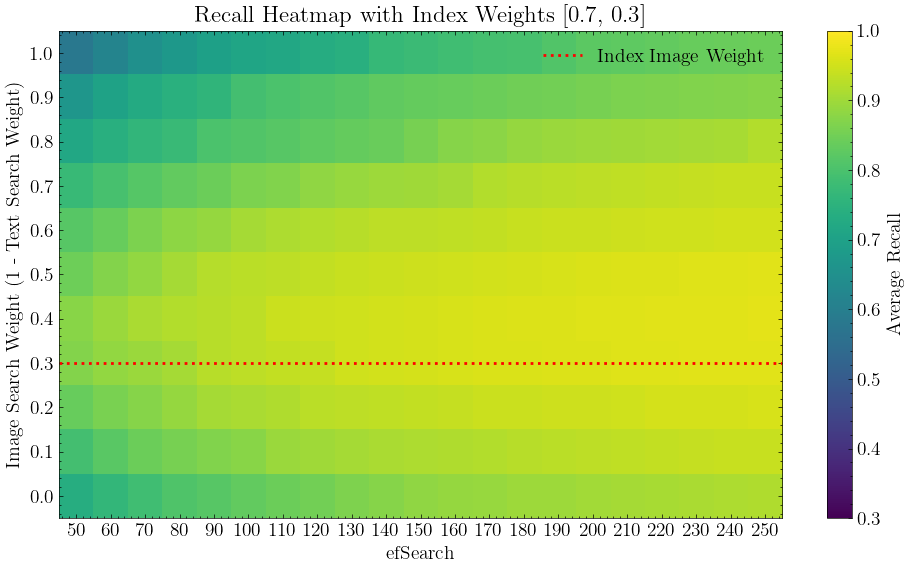

Loaded index-2025-04-16_05-04-50-348
Read values for k=50 for dataset size 1000000 for 36 ef values
0.8 80


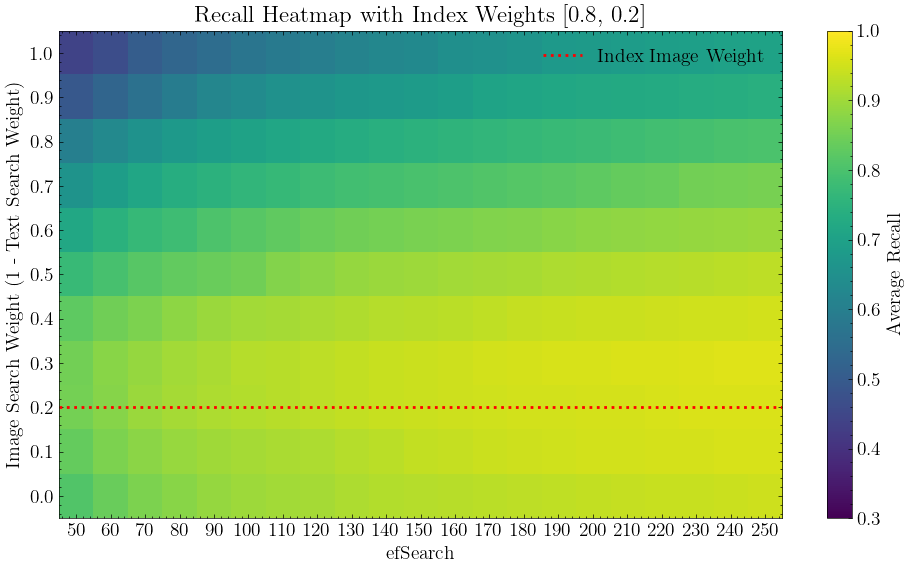

Loaded index-2025-04-16_05-26-36-702
Read values for k=50 for dataset size 1000000 for 36 ef values
0.9 90


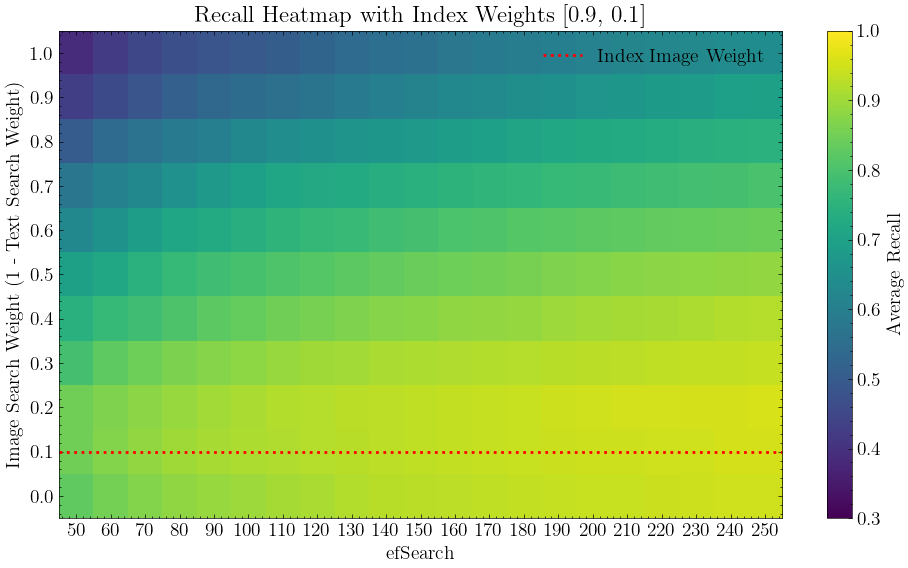

Loaded index-2025-04-16_05-46-41-453
Read values for k=50 for dataset size 1000000 for 36 ef values
1.0 100


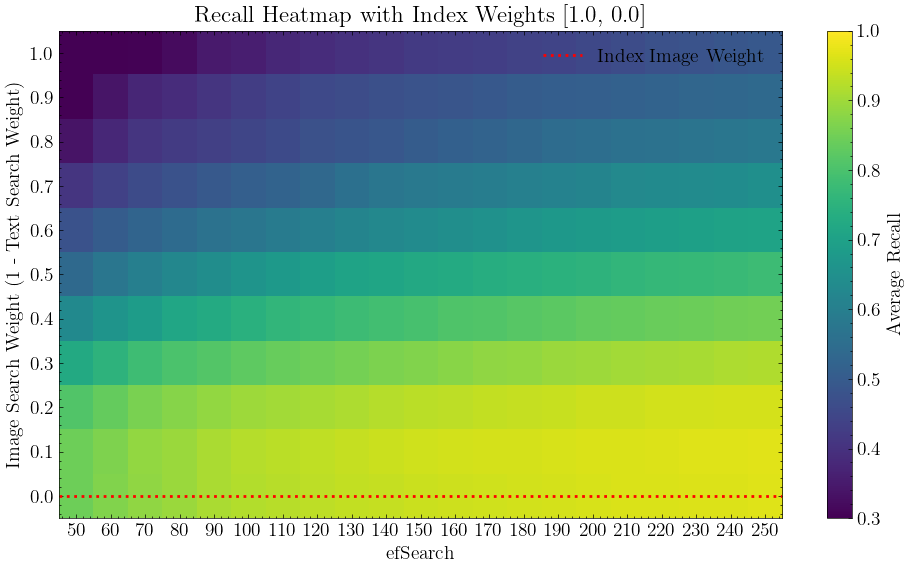

In [53]:
for text_weight in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[text_weight, round(1-text_weight, 5)], index_size=1_000_000)
    search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=60)

    prev_experiment_folder = 1
    search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, base_folder=STATS_SEARCH_EXPS_FOLDER, prev_experiment_folder=prev_experiment_folder)
    search_weights_exp_params.k = k

    plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

Loaded index-2025-04-16_03-10-18-738
Read values for k=50 for dataset size 1000000 for 36 ef values
0.2 20


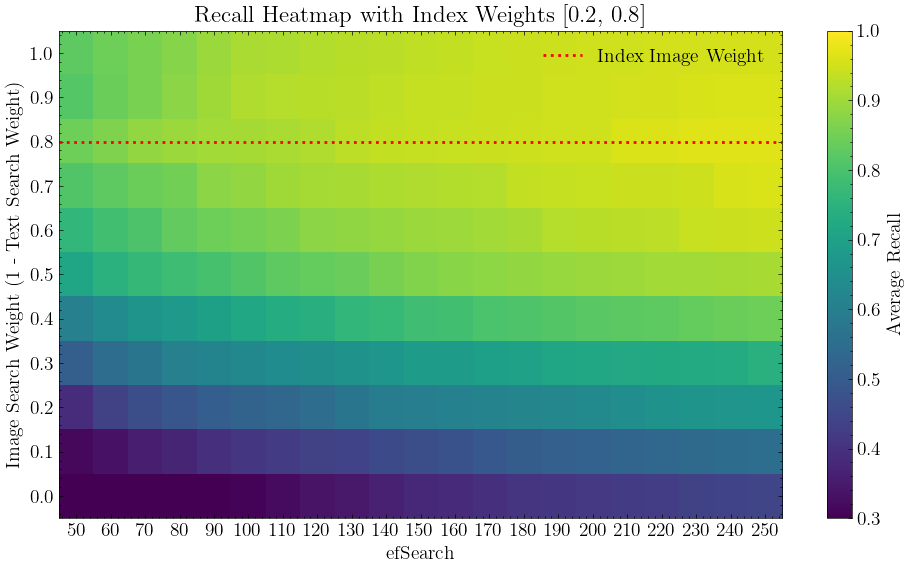

Loaded index-2025-04-16_04-03-26-685
Read values for k=50 for dataset size 1000000 for 36 ef values
0.5 50


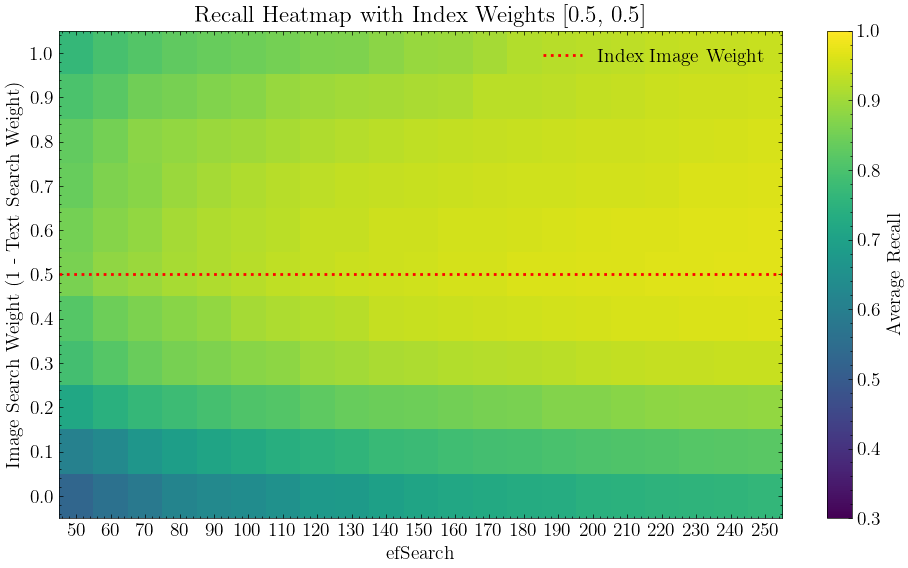

Loaded index-2025-04-16_05-04-50-348
Read values for k=50 for dataset size 1000000 for 36 ef values
0.8 80


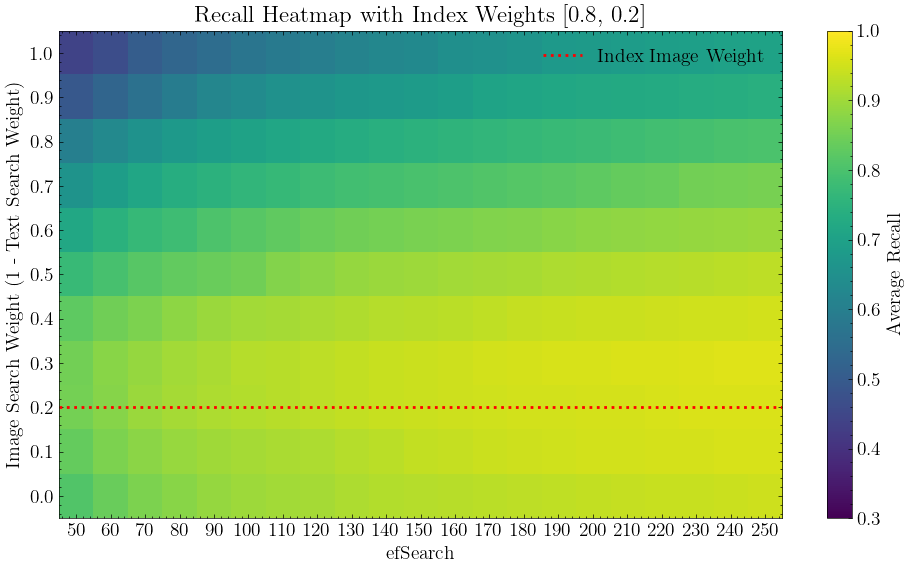

In [54]:
for text_weight in [0.2, 0.5, 0.8]:
    search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[text_weight, round(1-text_weight, 5)], index_size=1_000_000)
    search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=60)

    prev_experiment_folder = 1
    search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, base_folder=STATS_SEARCH_EXPS_FOLDER, prev_experiment_folder=prev_experiment_folder)
    search_weights_exp_params.k = k

    plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def create_combined_heatmap(params, text_weights, construction_params, max_ef=250, plot_by_image=True):
    # 3 subplots in 1 figure
    fig, axes = plt.subplots(1, 3, figsize=(36, 7))
    fig.suptitle("Recall Heatmaps for Various Weighted Indexes", fontsize=24, y=0.95)

    vmin, vmax = 0.31, 1.0
    all_heatmap_data = []
    # first collect data
    for text_weight in text_weights:
        params.weights = [text_weight, round(1-text_weight, 5)]

        search_weights_data, k = get_search_weights_data(params, construction_params,
                                                       base_folder=STATS_SEARCH_EXPS_FOLDER,
                                                       prev_experiment_folder=1)

        if plot_by_image:
            transformed_data = {}
            for weight, ef_dict in search_weights_data.items():
                new_weight = round(1.0 - weight, 5)
                transformed_data[new_weight] = ef_dict
        else:
            transformed_data = search_weights_data

        weights = sorted(transformed_data.keys())
        efs = sorted({ef for ef_dict in transformed_data.values() for ef in ef_dict if ef <= max_ef})

        heatmap_data = np.zeros((len(weights), len(efs)))
        for i, weight in enumerate(weights):
            for j, ef in enumerate(efs):
                recall_list = transformed_data[weight][ef]
                heatmap_data[i, j] = np.mean(recall_list)

        all_heatmap_data.append(heatmap_data)
        #vmin = min(vmin, np.min(heatmap_data))
        #vmax = max(vmax, np.max(heatmap_data))

    # plot with consistent colors
    for idx, (text_weight, ax) in enumerate(zip(text_weights, axes)):
        heatmap_data = all_heatmap_data[idx]
        im = ax.imshow(heatmap_data, aspect='auto', origin='lower',
                      cmap='viridis', vmin=vmin, vmax=vmax)
        # plot the index weight line
        if plot_by_image:
            target_weight = round(1.0 - text_weight, 5)
            weights = sorted({round(1.0 - w, 5) for w in search_weights_data.keys()})
        else:
            target_weight = text_weight
            weights = sorted({w for w in search_weights_data.keys()})

        y_pos = weights.index(target_weight)
        ax.axhline(y=y_pos, color='red', linestyle=':', linewidth=2, label=f'Index Weight')
        ax.legend(loc='upper right')

        ax.set_xticks(np.arange(len(efs)))
        ax.set_xticklabels(efs, fontsize=12)
        ax.set_yticks(np.arange(len(weights)))
        ax.set_yticklabels([f"{w:.1f}" for w in weights])

        ax.set_xlabel("efSearch", fontsize=16)
        if idx == 0:
            if plot_by_image:
                ax.set_ylabel("Image Search Weight", fontsize=16)
            else:
                ax.set_ylabel("Text Search Weight", fontsize=16)

    # single colorbar for all 3 subplots
    cbar = fig.colorbar(im, ax=axes.ravel().tolist())
    cbar.set_label("Average Recall", fontsize=16)

    plt.savefig(f"{PLOT_DIR}/search_weights/combined_recall_heatmap_{params.index_size}_{params.metrics[0]}_{params.metrics[1]}_weight_{int(params.weights[0]*100)}_ef{construction_params.ef_construction}_seed_{construction_params.seed}_k{params.k}.pdf", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

Loaded index-2025-04-16_03-10-18-738
Read values for k=50 for dataset size 1000000 for 36 ef values
Loaded index-2025-04-16_04-03-26-685
Read values for k=50 for dataset size 1000000 for 36 ef values
Loaded index-2025-04-16_05-04-50-348
Read values for k=50 for dataset size 1000000 for 36 ef values


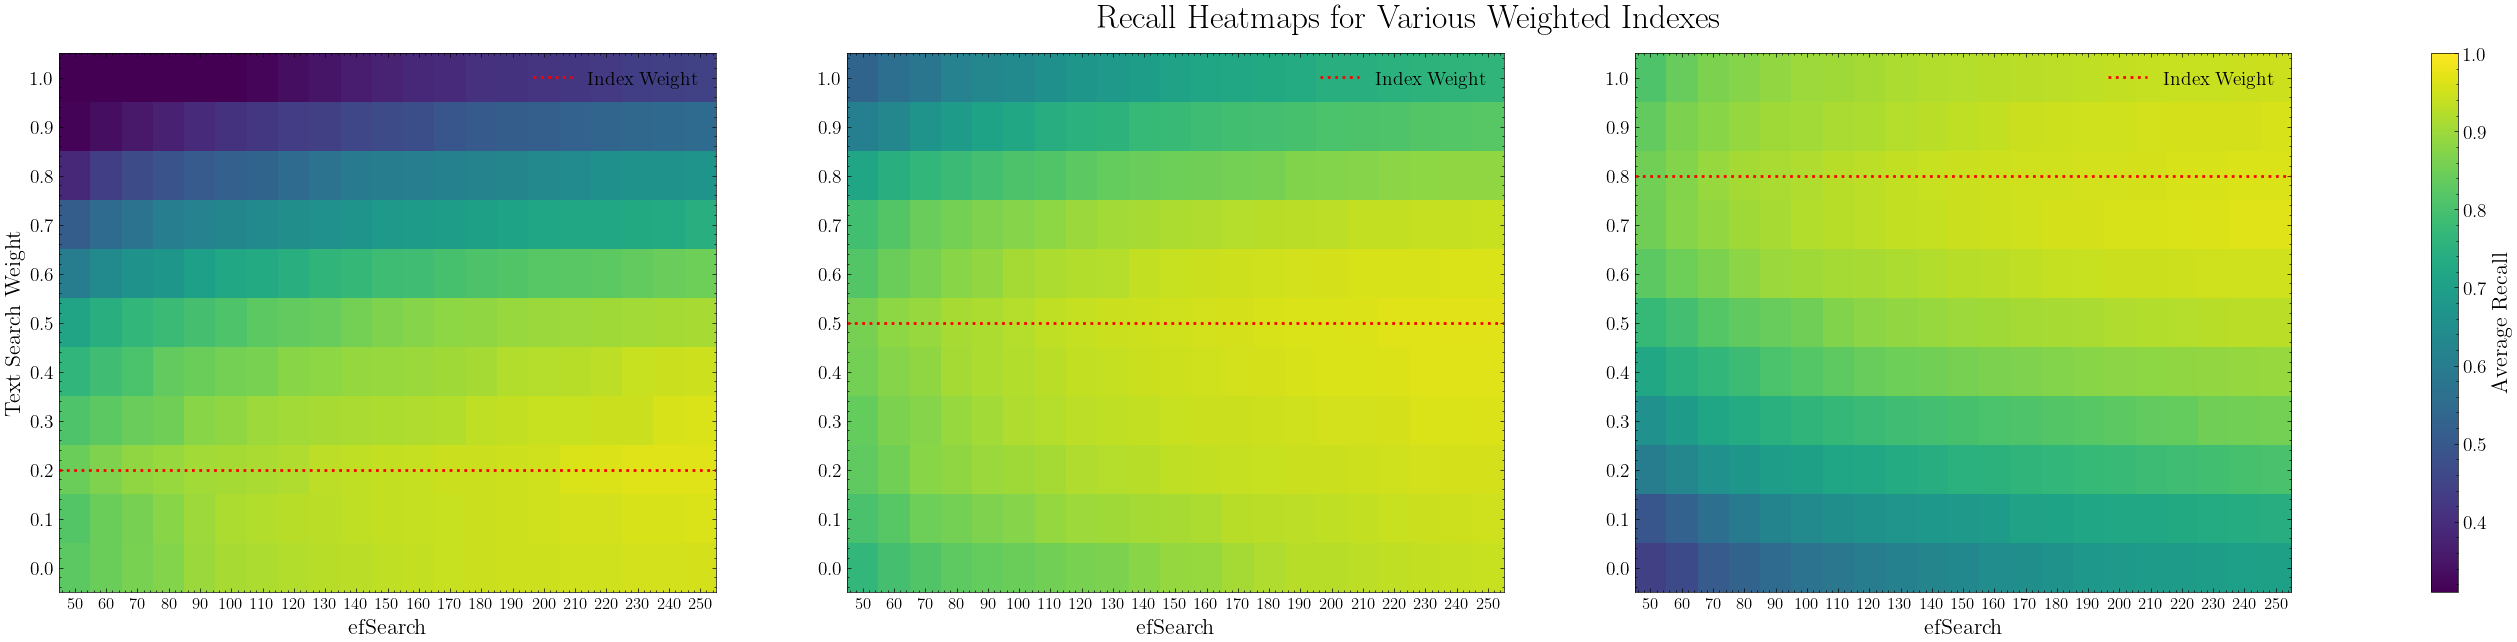

In [24]:
params = Params(modalities=2, dimensions=[384, 768],
                          metrics=["cosine", "cosine"],
                          weights=[-1,-1],
                          index_size=1_000_000)
construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=60)
create_combined_heatmap(params, [0.2, 0.5, 0.8], construction_params, max_ef=250, plot_by_image=False)

In [6]:
def plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_dir=PLOT_DIR, plot_time=True, index_seed=None, normalised=""):
    # plot the distance calls for each text weight
    fig, ax = plt.subplots(figsize=(10, 6))
    x_val = list(times.keys())
    assert len(x_val) == len(total_distance_calls), f"Length mismatch: {len(x_val)} vs {len(total_distance_calls)}"
    assert len(x_val) == len(num_lazy_distance_cutoffs), f"Length mismatch: {len(x_val)} vs {len(num_lazy_distance_cutoffs)}"

    # plot times on the same plot but on the right y-axis
    if plot_time:
        ax1 = ax
        ax1.plot(times.keys(), times.values(), label="Construction Time", color='red', marker='s', zorder=20)
        ax1.set_ylim(400, 1500)
        ax1.set_ylabel("Construction Time (s)", color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.set_xlabel("Index Text Weight (1- Image Weight)")

    if plot_time:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    ax2.plot(total_distance_calls.keys(), total_distance_calls.values(), label="Total Distance Computations", marker='o', zorder=30)
    ax2.plot(num_lazy_distance_cutoffs.keys(), num_lazy_distance_cutoffs.values(), label="Total Distance Computations Cutoff", marker='^', zorder=29)
    ax2.set_ylabel("Number of Distance Computations")

    if plot_time:
        # plot ax on top of ax2
        ax1.set_zorder(11)
        ax2.set_zorder(12)
        ax1.patch.set_visible(False)

        ax1.yaxis.tick_right()
        ax1.yaxis.set_label_position("right")

    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    ax.set_title(f"1M Index Construction Stats for Metrics [{params.metrics[0].capitalize()}, {params.metrics[1].capitalize()}]")

    if plot_time:
        # combine legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines2 += lines
        labels2 += labels
        ax2.legend(lines2, labels2) #loc="upper left")
    else:
        ax2.legend()

    ax2.grid()
    if plot_time:
        ax1.grid(axis="x")

    # save plot
    if not os.path.exists(f"{plot_dir}/weights-construction"):
        os.makedirs(f"{plot_dir}/weights-construction")
    plt.savefig(f"{plot_dir}/weights-construction/distance_calls_{normalised.split('/')[0]}{params.index_size}_{params.metrics[0]}-{params.metrics[1]}_seed_{index_seed}.pdf", dpi=FIGURE_DPI, bbox_inches='tight', format='pdf')
    plt.show()

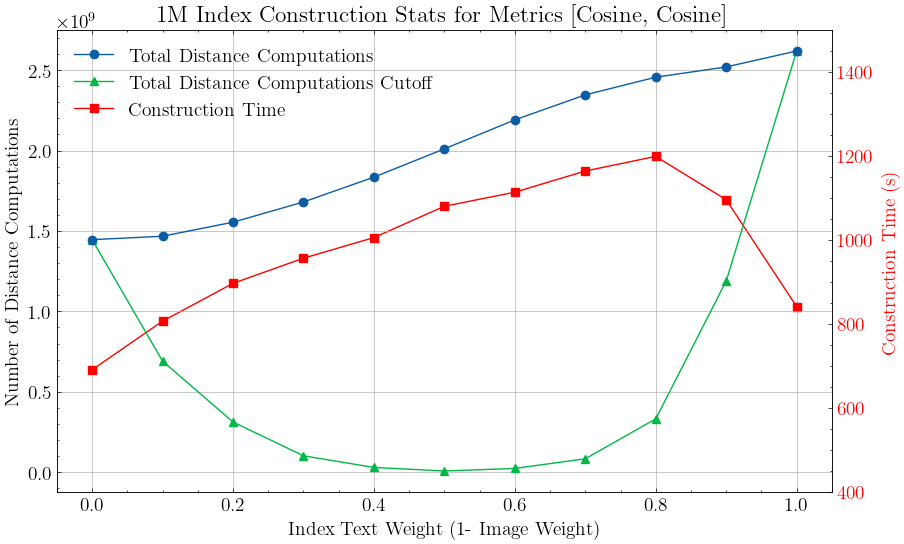

In [18]:
seed = 60
params, times, _, _, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["cosine", "cosine"], seed=seed, base_folder=STATS_BASE_FOLDER)
plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

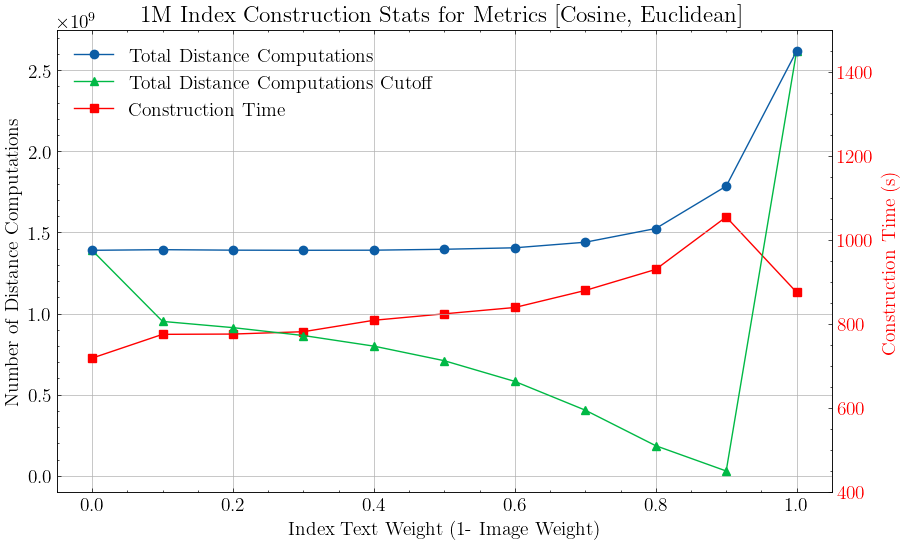

In [35]:
seed = 60
params, times, _, _, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["cosine", "euclidean"], seed=seed, base_folder=STATS_BASE_FOLDER)
plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

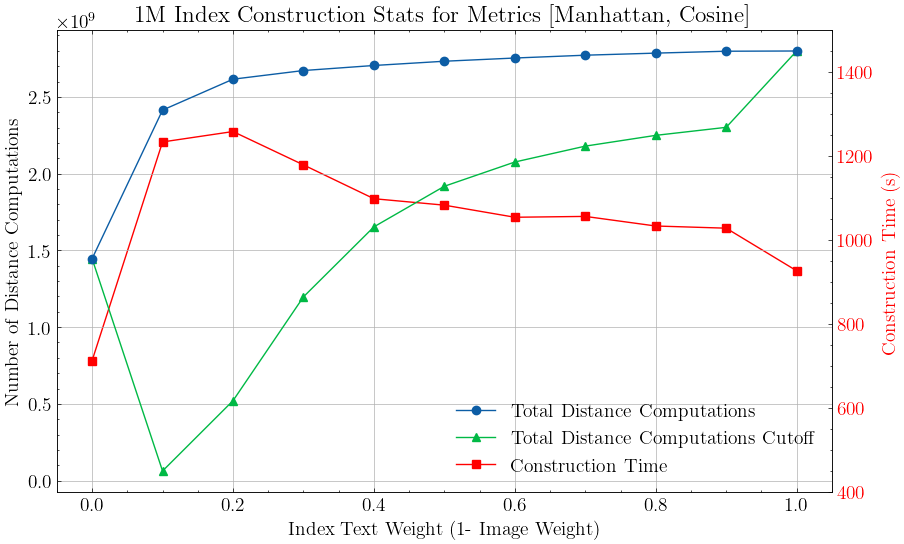

In [36]:
seed = 60
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["manhattan", "cosine"], seed=60,base_folder=STATS_BASE_FOLDER)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

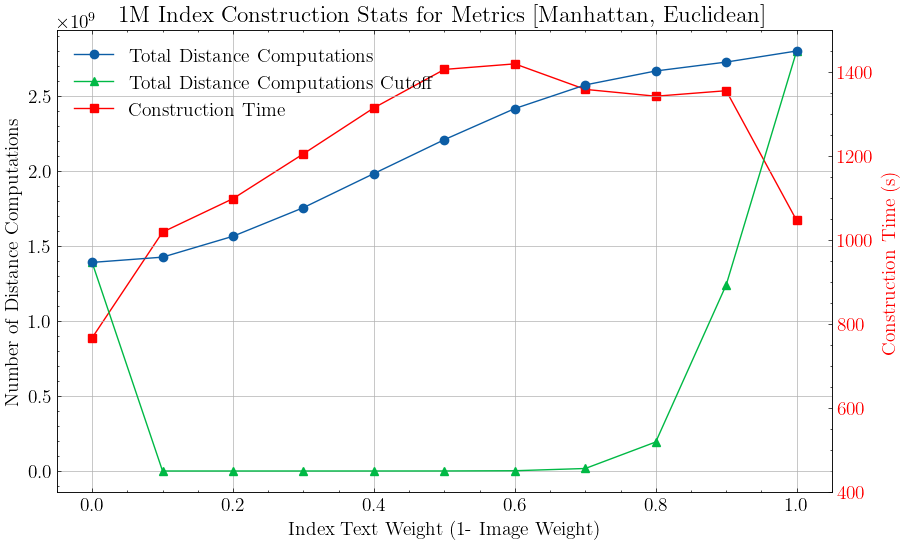

In [37]:
seed = 60
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["manhattan", "euclidean"], seed=60,base_folder=STATS_BASE_FOLDER)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

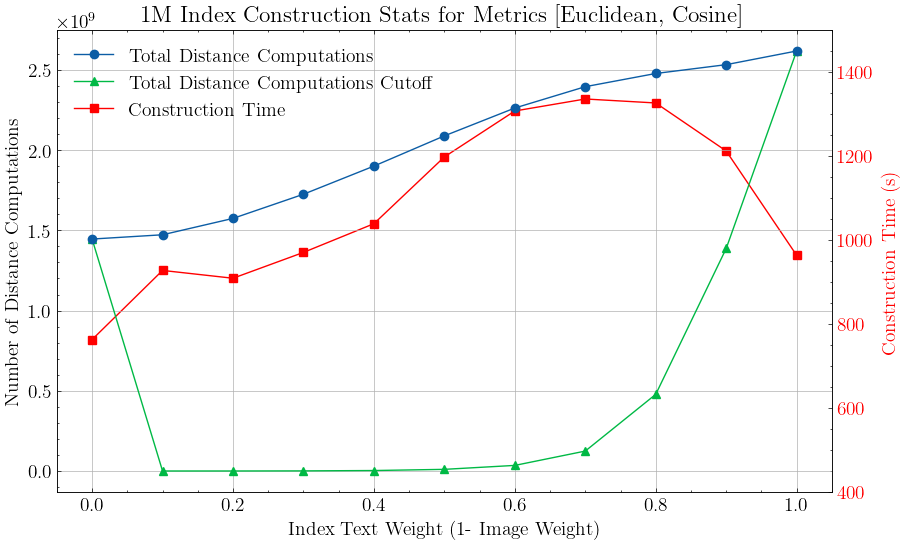

In [38]:
seed = 60
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["euclidean", "cosine"], seed=60, base_folder=STATS_BASE_FOLDER)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

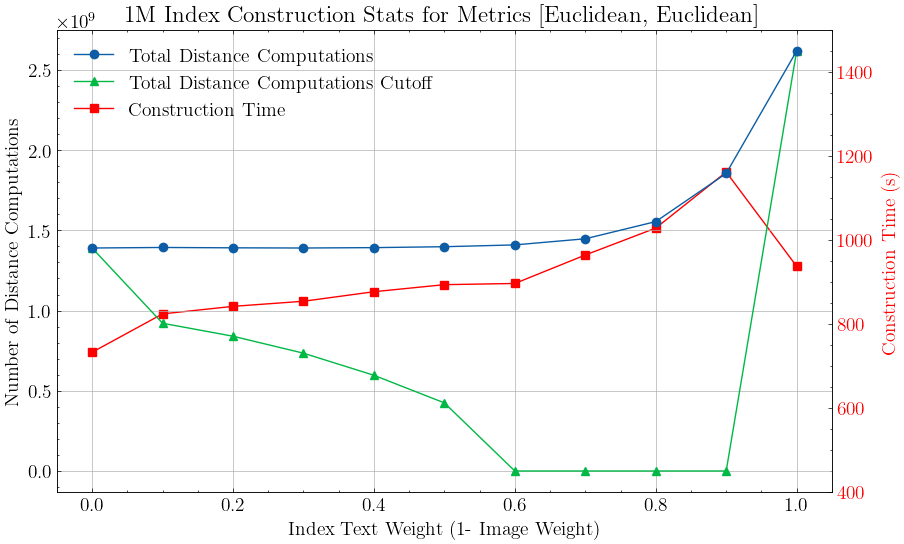

In [39]:
seed = 60
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["euclidean", "euclidean"], seed=60, base_folder=STATS_BASE_FOLDER)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

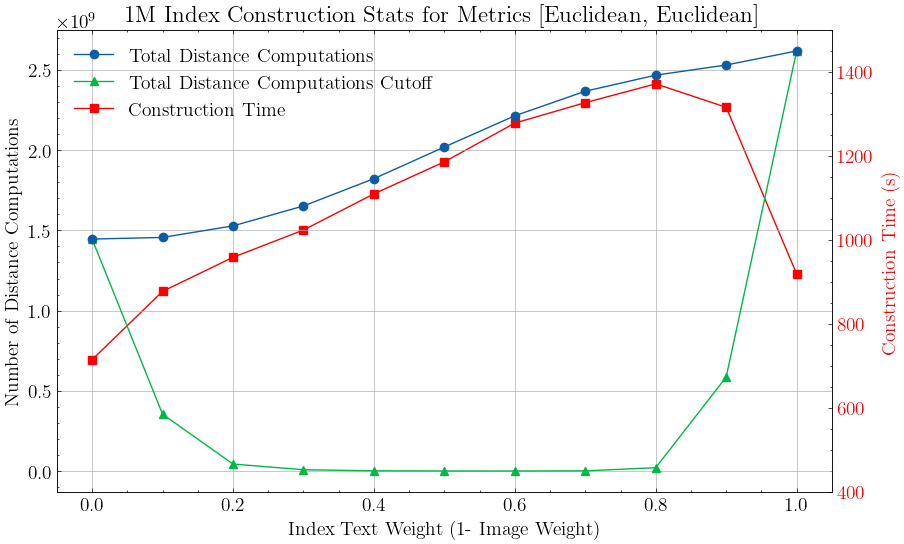

In [40]:
seed = 60
normalised="normalised/"
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["euclidean", "euclidean"], seed=60, normalised=normalised, base_folder=STATS_BASE_FOLDER)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed, normalised=normalised)

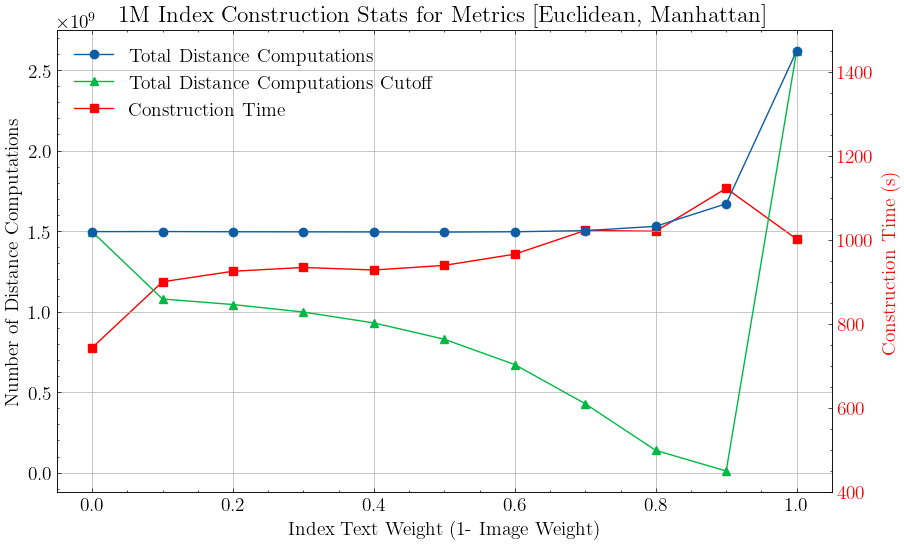

In [41]:
seed = 60
normalised = "normalised/"
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["euclidean", "manhattan"], seed=60, normalised=normalised, base_folder=STATS_BASE_FOLDER)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed, normalised=normalised)

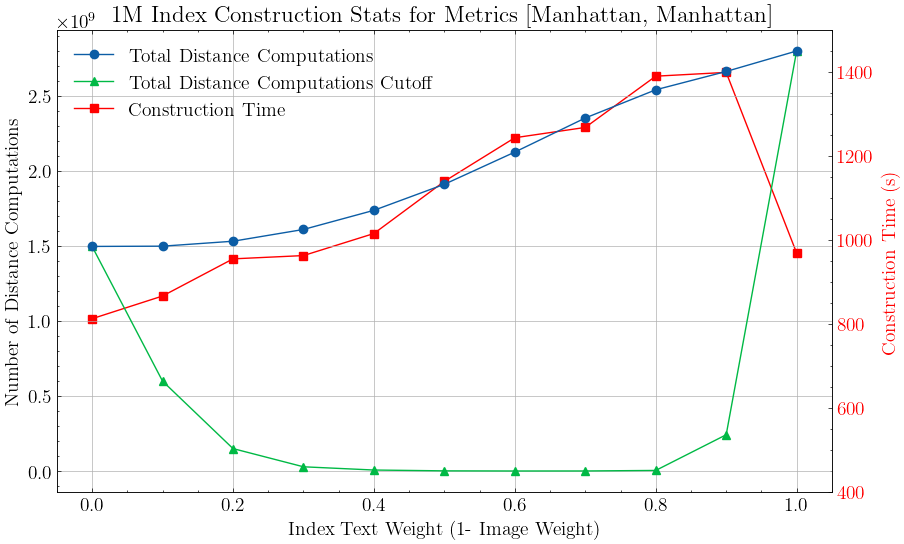

In [19]:
seed = 60
normalised = "normalised/"
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["manhattan", "manhattan"], seed=60, normalised=normalised, base_folder=STATS_BASE_FOLDER)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed, normalised=normalised)

In [8]:
def plot_construction_distance_calls_only_with_ci(params, total_distance_calls, num_lazy_distance_cutoffs, plot_dir=PLOT_DIR, times=None, time_confidence=0.95, no_reorder_times=None):
    # plot the distance calls for each text weight
    fig, ax = plt.subplots(figsize=(10, 6))
    assert len(total_distance_calls) == len(num_lazy_distance_cutoffs), f"Length mismatch: {len(total_distance_calls)} vs {len(num_lazy_distance_cutoffs)}"

    plot_time = False if times is None else True

    # get confidence intervals
    total_distance_means, total_distance_cis = compute_means_and_cis_from_dict_of_list(total_distance_calls)
    cutoff_means, cutoff_cis = compute_means_and_cis_from_dict_of_list(num_lazy_distance_cutoffs)
    if plot_time: times_means, times_cis = compute_means_and_cis_from_dict_of_list(times, time_confidence)

    # plot times on the same plot but on the right y-axis
    if plot_time:
        ax1 = ax

        # plot no-reorder times
        if no_reorder_times is not None:
            no_reorder_means, no_reorder_cis = compute_means_and_cis_from_dict_of_list(no_reorder_times, time_confidence)
            ax1.plot(no_reorder_times.keys(), no_reorder_means, label="Time Without Lazy Computation", color='red', marker='s', zorder=20)
            ax1.fill_between(times.keys(), no_reorder_means-no_reorder_cis, no_reorder_means+no_reorder_cis, color='red', alpha=0.2, zorder=19)

        # plot times
        ax1.plot(times.keys(), times_means, label="Time With Lazy Computation", color='green', marker='x', zorder=20, linestyle="dashed")
        ax1.fill_between(times.keys(), times_means-times_cis, times_means+times_cis, color='green', alpha=0.2, zorder=19)


        ax1.set_ylim(500, 1500)
        #ax1.set_ylabel("Construction Time (s)", color='red')
        ax1.set_ylabel("Construction Time (s)")
        #ax1.tick_params(axis='y', labelcolor='red')
        ax1.tick_params(axis='y')
        ax1.set_xlabel("Index Text Weight (1- Image Weight)")

    if plot_time:
        ax2 = ax.twinx()
    else:
        ax2 = ax

    # plot total distance and cutoff graphs with confidence intervals
    ax2.plot(total_distance_calls.keys(), total_distance_means, label="Total Distance Computation", marker='o', zorder=30, color='blue')
    ax2.fill_between(total_distance_calls.keys(), total_distance_means - total_distance_cis, total_distance_means + total_distance_cis, alpha=0.2, zorder=20, color='blue')

    ax2.plot(num_lazy_distance_cutoffs.keys(), cutoff_means, label="Total Distance Computation Cutoff", marker='^', zorder=29, color='skyblue', linestyle='dashed')
    ax2.fill_between(num_lazy_distance_cutoffs.keys(), cutoff_means - cutoff_cis, cutoff_means + cutoff_cis, alpha=0.2, zorder=20, color='skyblue')

    ax2.set_ylabel("Number of Distance Computations")

    if plot_time:
        # plot ax on top of ax2
        ax1.set_zorder(11)
        ax2.set_zorder(12)
        ax1.patch.set_visible(False)

        ax1.yaxis.tick_right()
        ax1.yaxis.set_label_position("right")

    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    ax.set_xlabel("Index Text Weight (1- Image Weight)")
    ax.set_title(f"Impact of Lazy Distance Computation for {metrics_to_str(params.metrics)} (1M Index)")

    if plot_time:
        # combine legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines2 += lines
        labels2 += labels
        ax2.legend(lines2, labels2) #loc="upper left")
    else:
        ax2.legend()

    ax2.grid()
    if plot_time:
        ax1.grid(axis="x")

    # save plot
    if not os.path.exists(f"{plot_dir}/weights-construction"):
        os.makedirs(f"{plot_dir}/weights-construction")
    no_reorder_string = "with-no-reorder_" if no_reorder_times is not None else ""
    plt.savefig(f"{plot_dir}/weights-construction/distance_calls_with_ci_" + no_reorder_string + f"{params.index_size}_{params.metrics[0]}-{params.metrics[1]}_seed_MANY.pdf", dpi=FIGURE_DPI, bbox_inches='tight', format='pdf')
    plt.show()

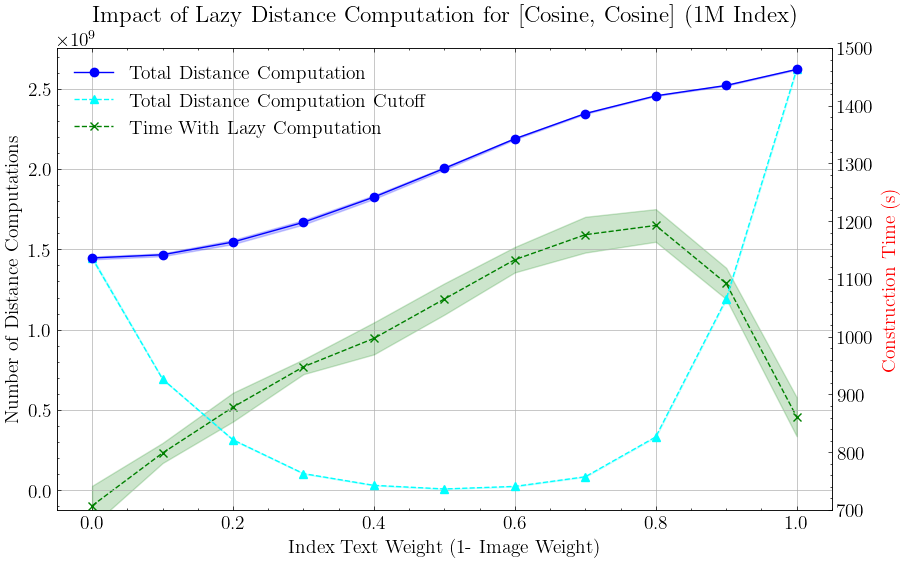

In [27]:
total_distance_calls = defaultdict(list)
num_lazy_distance_cutoffs = defaultdict(list)
all_times = defaultdict(list)
for seed in [60, 50, 51, 61]:
    params, times, _, _, total_distance_calls_temp, num_lazy_distance_cutoffs_temp = get_construction_data_per_metric_and_seed(["cosine", "cosine"], seed=seed, base_folder=STATS_BASE_FOLDER)
    keys = list(total_distance_calls_temp.keys())
    for key in keys:
        total_distance_calls[key].append(total_distance_calls_temp[key])
        num_lazy_distance_cutoffs[key].append(num_lazy_distance_cutoffs_temp[key])
        all_times[key].append(times[key][0])

plot_construction_distance_calls_only_with_ci(params, total_distance_calls, num_lazy_distance_cutoffs, times=all_times)

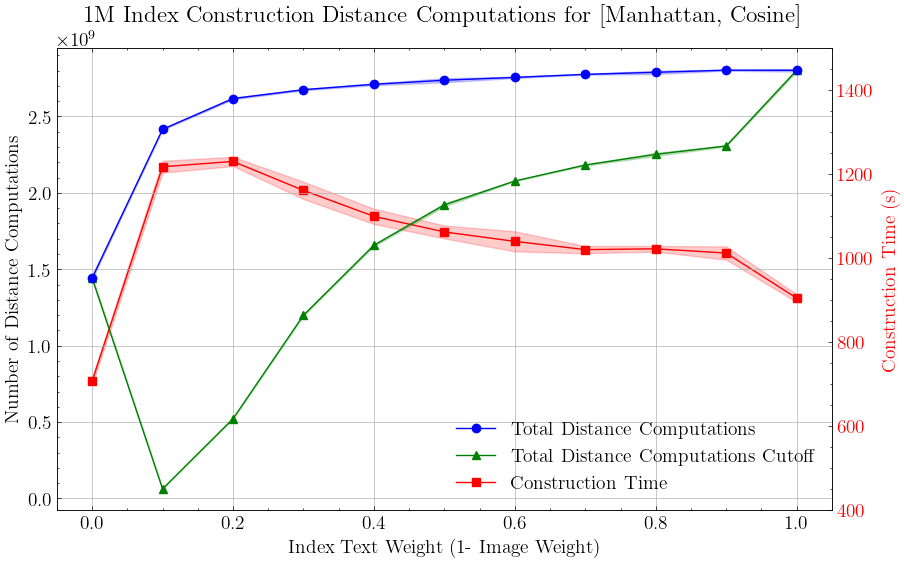

In [26]:
total_distance_calls = defaultdict(list)
num_lazy_distance_cutoffs = defaultdict(list)
all_times = defaultdict(list)
for seed in [100, 101, 102]: #60, 100, 101, 102, 103
    if seed == 60:
        normalised=""
    else:
        normalised="normalised/"
    params, times, _, _, total_distance_calls_temp, num_lazy_distance_cutoffs_temp = get_construction_data_per_metric_and_seed(["manhattan", "cosine"], seed=seed, normalised=normalised, base_folder=STATS_BASE_FOLDER)
    keys = list(total_distance_calls_temp.keys())
    for key in keys:
        total_distance_calls[key].append(total_distance_calls_temp[key])
        num_lazy_distance_cutoffs[key].append(num_lazy_distance_cutoffs_temp[key])
        all_times[key].append(times[key][0])

plot_construction_distance_calls_only_with_ci(params, total_distance_calls, num_lazy_distance_cutoffs, times=all_times)

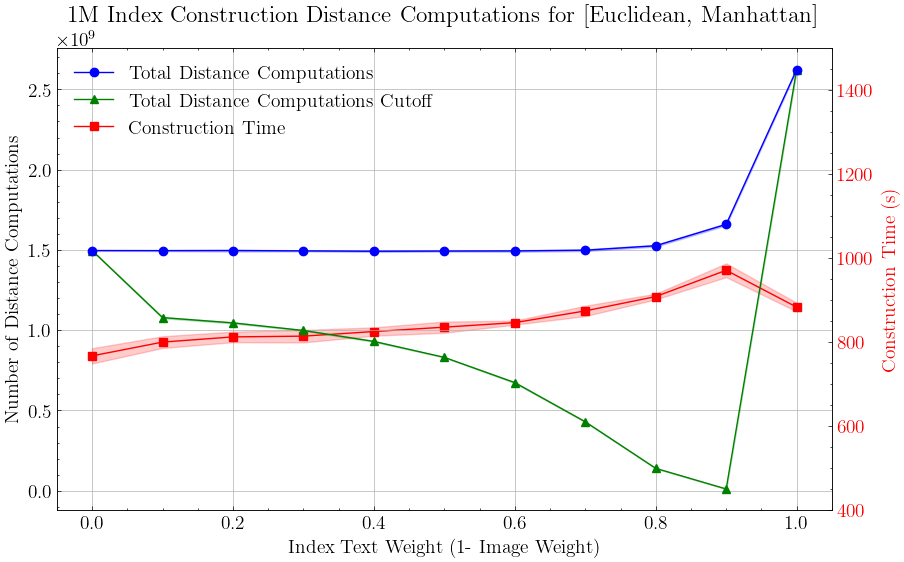

In [27]:
total_distance_calls = defaultdict(list)
num_lazy_distance_cutoffs = defaultdict(list)
all_times = defaultdict(list)
for seed in [100, 101, 102, 103]: # 100, 101, 102, 103
    normalised="normalised/"
    params, times, _, _, total_distance_calls_temp, num_lazy_distance_cutoffs_temp = get_construction_data_per_metric_and_seed(["euclidean", "manhattan"], seed=seed, normalised=normalised, base_folder=STATS_BASE_FOLDER)
    keys = list(total_distance_calls_temp.keys())
    for key in keys:
        total_distance_calls[key].append(total_distance_calls_temp[key])
        num_lazy_distance_cutoffs[key].append(num_lazy_distance_cutoffs_temp[key])
        all_times[key].append(times[key][0])

plot_construction_distance_calls_only_with_ci(params, total_distance_calls, num_lazy_distance_cutoffs, times=all_times)

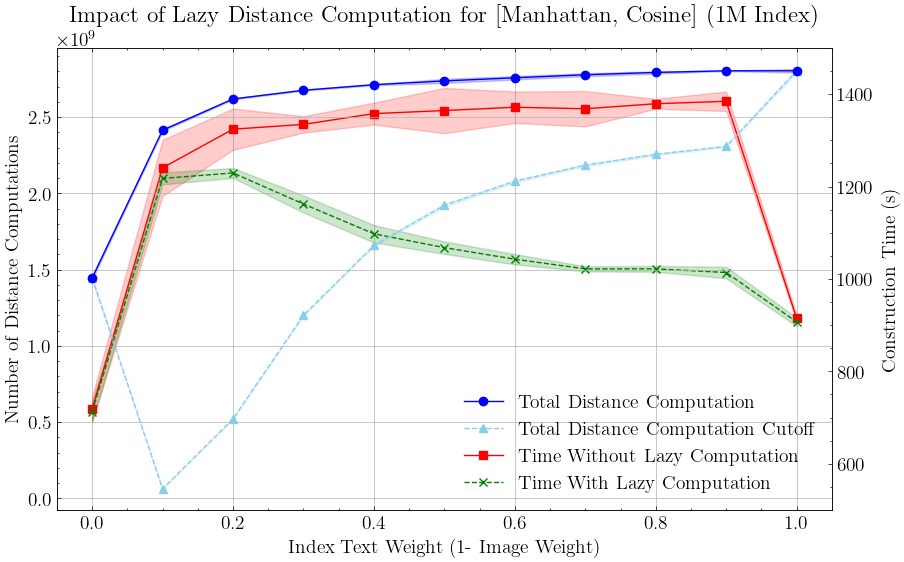

In [38]:
# time against no reorder
total_distance_calls = defaultdict(list)
num_lazy_distance_cutoffs = defaultdict(list)
all_times = defaultdict(list)
metrics = ["manhattan", "cosine"]
for seed in [100, 102, 103]: # 100, 101, 102, 103
    normalised="normalised/"
    params, times, _, _, total_distance_calls_temp, num_lazy_distance_cutoffs_temp = get_construction_data_per_metric_and_seed(metrics, seed=seed, normalised=normalised, base_folder=STATS_BASE_FOLDER)
    keys = list(total_distance_calls_temp.keys())
    for key in keys:
        total_distance_calls[key].append(total_distance_calls_temp[key])
        num_lazy_distance_cutoffs[key].append(num_lazy_distance_cutoffs_temp[key])
        all_times[key].append(times[key][0])

use_no_stats = False
if use_no_stats:
    all_times = defaultdict(list) # reset previous stats based times
    for seed in [102]:
        normalised="normalised/"
        params, times, _, _, _, _ = get_construction_data_per_metric_and_seed(metrics, seed=seed, normalised=normalised, base_folder=BASE_DIR)
        keys = list(times.keys())
        for key in keys:
            all_times[key].append(times[key][0])

all_no_reorder_times = defaultdict(list)
for seed in [101, 102, 103]:
    normalised="normalised/nolazy/"
    params, no_reorder_times, _, _, _, _ = get_construction_data_per_metric_and_seed(metrics, seed=seed, normalised=normalised, base_folder=BASE_DIR)
    keys = list(no_reorder_times.keys())
    for key in keys:
        all_no_reorder_times[key].append(no_reorder_times[key][0])


plot_construction_distance_calls_only_with_ci(params, total_distance_calls, num_lazy_distance_cutoffs, times=all_times, no_reorder_times=all_no_reorder_times)

In [27]:
np.mean(num_lazy_distance_cutoffs[0.9]) / np.mean(total_distance_calls[0.9])
np.mean(total_distance_calls[0.9])

2804049470.3333335

In [28]:
np.mean(all_no_reorder_times[0.9])/ np.mean(all_times[0.9])

1.3654791084425442

In [29]:
t_stat, p_value = ttest_ind(all_no_reorder_times[0.9], all_times[0.9], equal_var=False, alternative='greater')
t_stat, p_value

(64.97964143401342, 1.7689849601727248e-06)

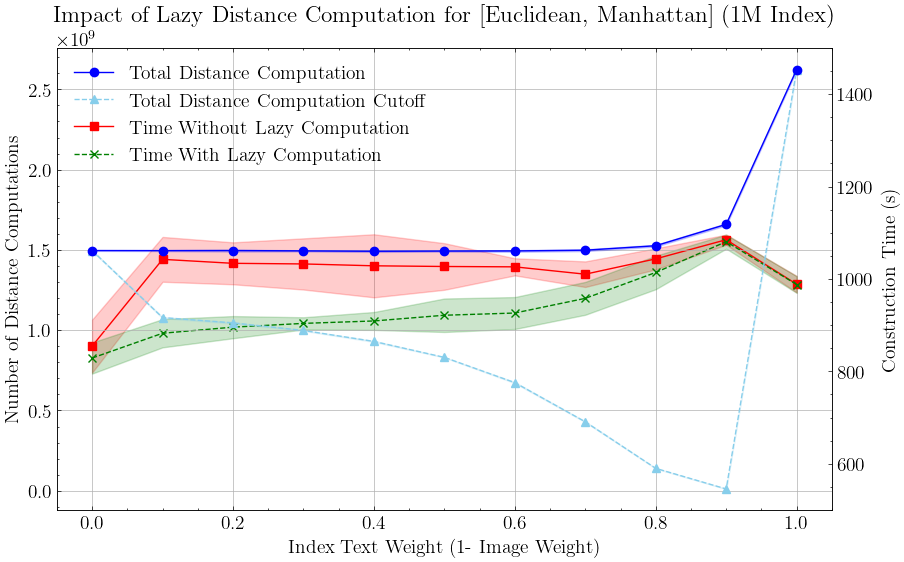

In [39]:
# time against no reorder
total_distance_calls = defaultdict(list)
num_lazy_distance_cutoffs = defaultdict(list)
all_times = defaultdict(list)
metrics = ["euclidean", "manhattan"]
for seed in [100, 101, 102, 103]: # 100, 101, 102, 103 from STATS_BASE_FOLDER
    normalised="normalised/"
    params, times, _, _, total_distance_calls_temp, num_lazy_distance_cutoffs_temp = get_construction_data_per_metric_and_seed(metrics, seed=seed, normalised=normalised, base_folder=STATS_BASE_FOLDER)
    keys = list(total_distance_calls_temp.keys())
    for key in keys:
        total_distance_calls[key].append(total_distance_calls_temp[key])
        num_lazy_distance_cutoffs[key].append(num_lazy_distance_cutoffs_temp[key])
        all_times[key].append(times[key][0])

use_no_stats = True
if use_no_stats:
    all_times = defaultdict(list) # reset previous stats based times
    for seed in [101,102,103,104, 105, 106]: # 101, 102, 103
        normalised="normalised/"
        params, times, _, _, _, _ = get_construction_data_per_metric_and_seed(metrics, seed=seed, normalised=normalised, base_folder=BASE_DIR)
        keys = list(times.keys())
        for key in keys:
            all_times[key].append(times[key][0])

all_no_reorder_times = defaultdict(list)
for seed in [101, 103,104,105, 107]: #outlier 102
    normalised="normalised/nolazy/"
    params, no_reorder_times, _, _, _, _ = get_construction_data_per_metric_and_seed(metrics, seed=seed, normalised=normalised, base_folder=BASE_DIR)
    keys = list(no_reorder_times.keys())
    for key in keys:
        all_no_reorder_times[key].append(no_reorder_times[key][0])


plot_construction_distance_calls_only_with_ci(params, total_distance_calls, num_lazy_distance_cutoffs, times=all_times, no_reorder_times=all_no_reorder_times)

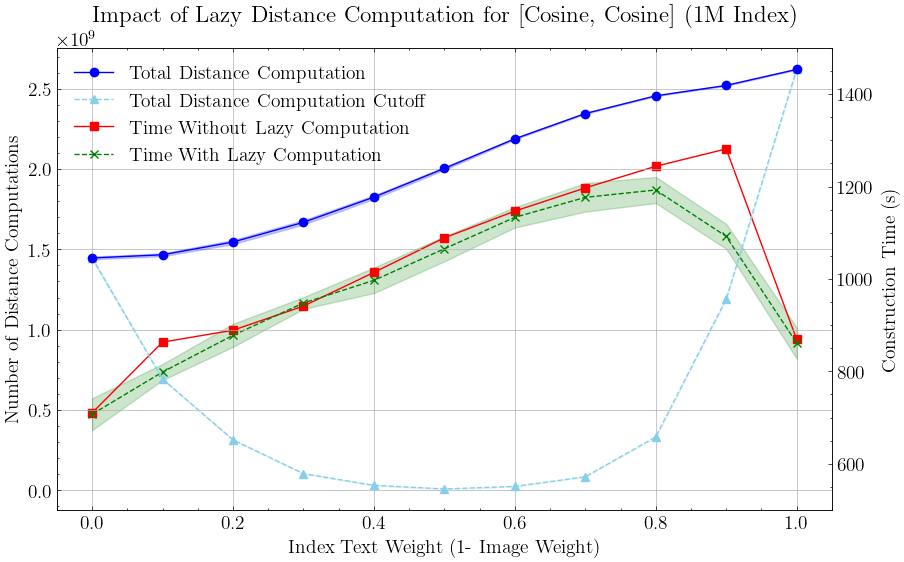

In [44]:
# time against no reorder
total_distance_calls = defaultdict(list)
num_lazy_distance_cutoffs = defaultdict(list)
all_times = defaultdict(list)
metrics = ["cosine", "cosine"]
for seed in [60, 50, 51, 61]: # 100, 101, 102, 103
    normalised=""
    params, times, _, _, total_distance_calls_temp, num_lazy_distance_cutoffs_temp = get_construction_data_per_metric_and_seed(metrics, seed=seed, normalised=normalised, base_folder=STATS_BASE_FOLDER)
    keys = list(total_distance_calls_temp.keys())
    for key in keys:
        total_distance_calls[key].append(total_distance_calls_temp[key])
        num_lazy_distance_cutoffs[key].append(num_lazy_distance_cutoffs_temp[key])
        all_times[key].append(times[key][0])

all_no_reorder_times = defaultdict(list)
for seed in [101]:
    normalised="normalised/nolazy/"
    params, no_reorder_times, _, _, _, _ = get_construction_data_per_metric_and_seed(metrics, seed=seed, normalised=normalised, base_folder=BASE_DIR)
    keys = list(no_reorder_times.keys())
    for key in keys:
        all_no_reorder_times[key].append(no_reorder_times[key][0])


plot_construction_distance_calls_only_with_ci(params, total_distance_calls, num_lazy_distance_cutoffs, times=all_times, no_reorder_times=all_no_reorder_times)

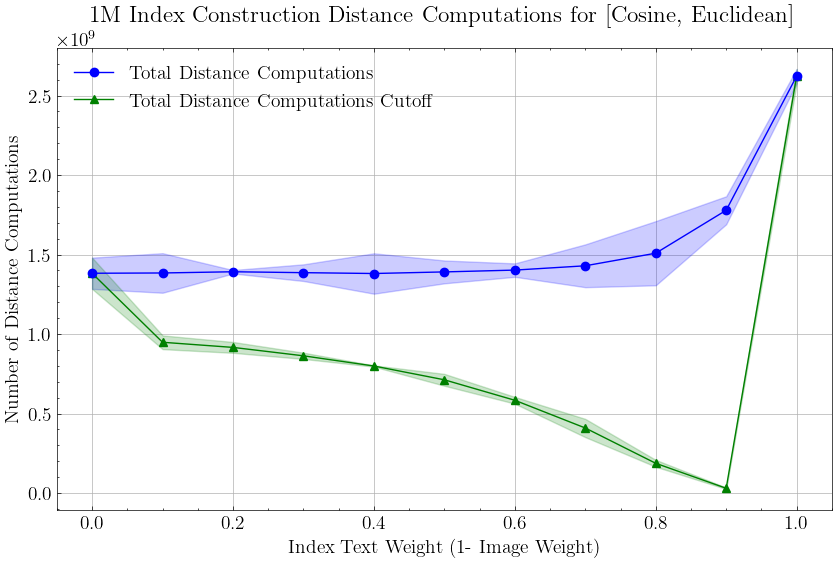

In [29]:
total_distance_calls = defaultdict(list)
num_lazy_distance_cutoffs = defaultdict(list)
normalised = ""
for seed in [60, 71]: #60, 71
    params, _, _, _, total_distance_calls_temp, num_lazy_distance_cutoffs_temp = get_construction_data_per_metric_and_seed(["cosine", "euclidean"], seed=seed, base_folder=STATS_BASE_FOLDER)
    keys = list(total_distance_calls_temp.keys())
    for key in keys:
        total_distance_calls[key].append(total_distance_calls_temp[key])
        num_lazy_distance_cutoffs[key].append(num_lazy_distance_cutoffs_temp[key])

plot_construction_distance_calls_only_with_ci(params, total_distance_calls, num_lazy_distance_cutoffs)

In [25]:
from src.experiments.plot_utils import compute_means_and_cis_from_dict_of_list, metrics_to_str

def plot_construction_distance_calls_for_metrics(metric_to_total_distance_calls, metric_to_num_lazy_distance_cutoffs, plot_dir=PLOT_DIR, index_size=1_000_000, index_seed=None, normalised="", legend_font_size="x-small"):
    # metric to total distance calls is a dict of dicts

    # plot the distance calls for each text weight
    fig, ax = plt.subplots(figsize=(10, 6))
    assert len(metric_to_total_distance_calls) == len(metric_to_num_lazy_distance_cutoffs), f"Length mismatch: {len(metric_to_total_distance_calls)} vs {len(metric_to_num_lazy_distance_cutoffs)}"

    markers = ['o', 's', '^', 'D', 'x', '+']
    for i, metrics in enumerate(metric_to_total_distance_calls.keys()):
        total_distance_calls = metric_to_total_distance_calls[metrics]
        num_lazy_distance_cutoffs = metric_to_num_lazy_distance_cutoffs[metrics]

        # plot total distance calculations for these metrics
        # plot with marker, but different across each call
        ax.plot(total_distance_calls.keys(), total_distance_calls.values(), label=metrics_to_str(metrics), marker=markers[i%len(markers)])
    ax.set_ylabel("Number of Distance Computations")
    ax.set_xlabel("Index Text Weight (1- Image Weight)")
    ax.set_title("Number of Distance Computations on 1M Index for Different Metrics")
    ax.grid()
    ax.legend(fontsize=legend_font_size)
    # save plot
    if not os.path.exists(f"{plot_dir}/weights-construction"):
        os.makedirs(f"{plot_dir}/weights-construction")
    plt.savefig(f"{plot_dir}/weights-construction/distance_calls_multiple_metrics_{normalised.split('/')[0]}{index_size}_seed_{index_seed}.pdf", dpi=FIGURE_DPI, bbox_inches='tight', format='pdf')
    plt.show()

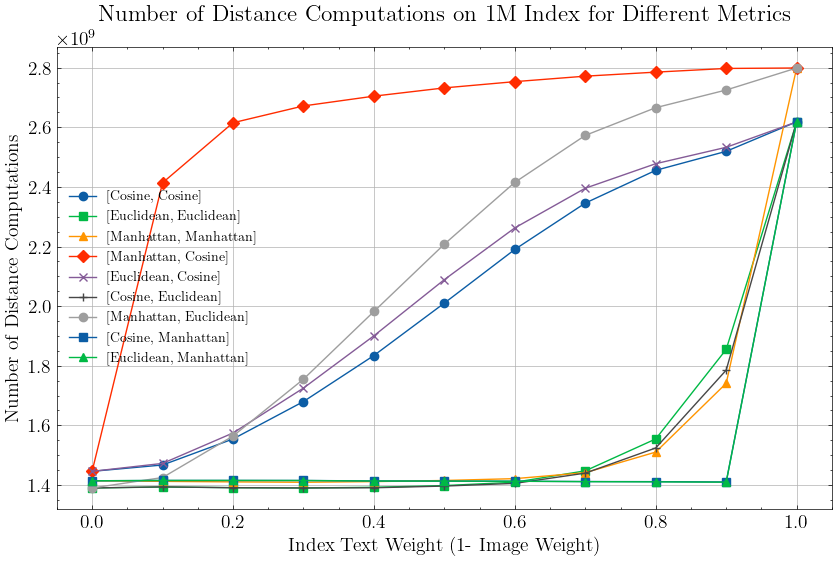

In [30]:
metric_to_total_distances, metric_to_cutoffs = get_metrics_data([("cosine", "cosine"), ("euclidean", "euclidean"), ("manhattan", "manhattan"), ("manhattan", "cosine"), ("euclidean", "cosine"), ("cosine", "euclidean"), ("manhattan", "euclidean"), ("cosine", "Manhattan"), ("euclidean", "Manhattan")], STATS_BASE_FOLDER)
plot_construction_distance_calls_for_metrics(metric_to_total_distances, metric_to_cutoffs, index_size=1000000, index_seed=60)

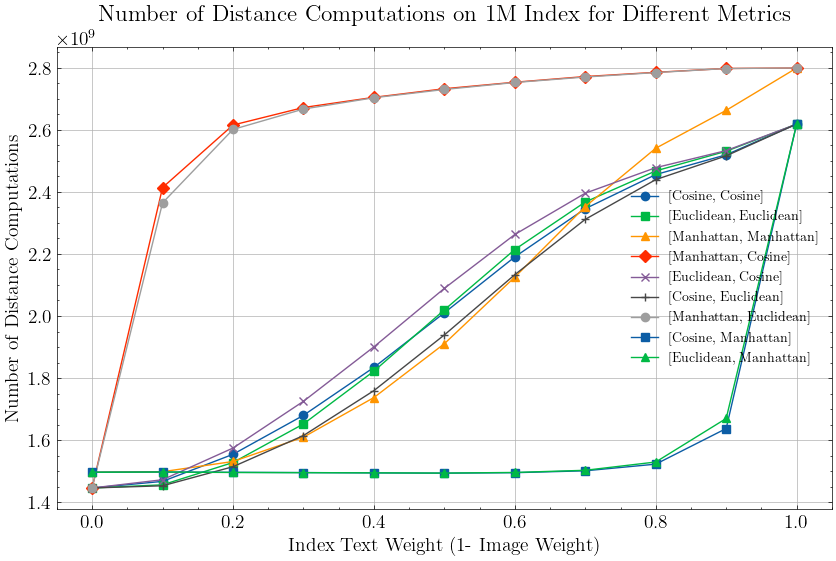

In [26]:
normalised = "normalised/"
metric_to_total_distances, metric_to_cutoffs = get_metrics_data([("cosine", "cosine"), ("euclidean", "euclidean"),  ("manhattan", "manhattan"), ("manhattan", "cosine"), ("euclidean", "cosine"),  ("cosine", "euclidean"), ("manhattan", "euclidean"), ("cosine", "manhattan"), ("euclidean", "manhattan")], STATS_BASE_FOLDER, normalised=normalised)
plot_construction_distance_calls_for_metrics(metric_to_total_distances, metric_to_cutoffs, index_size=1000000, index_seed=60, normalised=normalised)

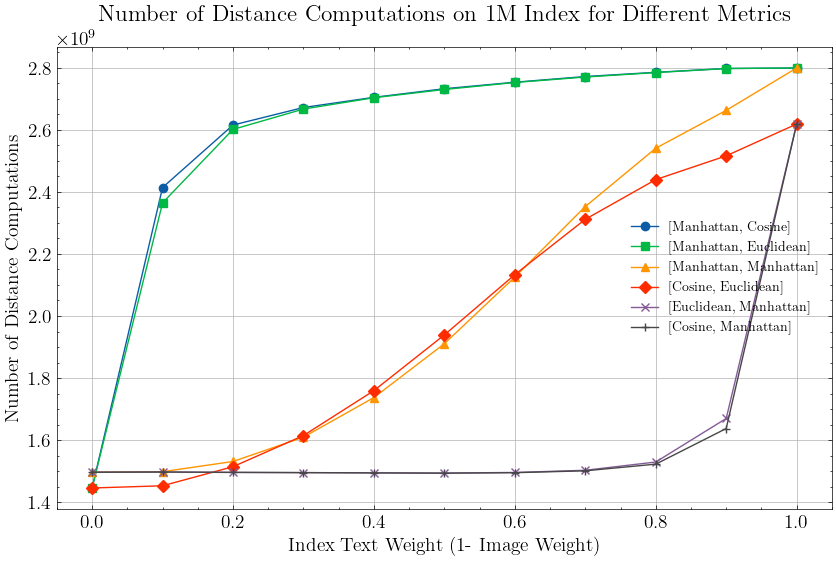

In [27]:
normalised = "normalised/"
metric_to_total_distances, metric_to_cutoffs = get_metrics_data([("manhattan", "cosine"),("manhattan", "euclidean"), ("manhattan", "manhattan"), ("manhattan", "cosine"),  ("cosine", "euclidean"), ("euclidean", "manhattan"), ("cosine", "manhattan")], STATS_BASE_FOLDER, normalised=normalised)
plot_construction_distance_calls_for_metrics(metric_to_total_distances, metric_to_cutoffs, index_size=1000000, index_seed=60, normalised=normalised, legend_font_size="x-small")

In [6]:
# plot recall at search weights equal to various constructed weights

In [11]:
def plot_heatmap_for_index_weights_recall_data(metrics, construction_params, recall_data, max_ef=float('inf'), plots_dir=PLOT_DIR, plot_by_image_weight=False):
    # recall_data is index_weights -> ef -> list of recall for 100 queries
    # we have 11 values for weights: 0.0 to 1.0, and around 15 for ef
    # for each cell combination, we plot a heatmap of the average of the recall values
    print("initial length:", len(recall_data[0.3][50]))
    if plot_by_image_weight:
        # we plot image weights, so first transform to 1-text_weight
        transformed_data = {}
        for weight, ef_dict in recall_data.items():
            new_weight = round(1.0 - weight, 5)
            transformed_data[new_weight] = ef_dict
    else:
        transformed_data = recall_data

    weights = sorted(transformed_data.keys())
    efs = sorted({ef for ef_dict in transformed_data.values() for ef in ef_dict if ef <= max_ef})
    print(efs)

    heatmap_data = np.zeros((len(weights), len(efs)))
    for i, weight in enumerate(weights):
        print(f"weight {weight} has {len(transformed_data[weight][50][0])} items")
        for j, ef in enumerate(efs):
            recall_list = transformed_data[weight][ef]
            assert len(recall_list) > 0, f"Missing data for weight {weight} and ef {ef}"
            heatmap_data[i, j] = np.mean(recall_list)

    plt.figure(figsize=(10, 6))
    im = plt.imshow(heatmap_data, aspect='auto', origin='lower', cmap='viridis')

    plt.xticks(ticks=np.arange(len(efs)), labels=efs)
    plt.yticks(ticks=np.arange(len(weights)), labels=[f"{w:.1f}" for w in weights])

    plt.xlabel("efSearch")
    if plot_by_image_weight:
        plt.ylabel("Image Index Weight (1 - Text Index Weight)")
    else:
        plt.ylabel("Text Index Weight (1 - Image Index Weight)")
    plt.title(f"Recall Heatmap for Varying Index Weights with Metrics {metrics_to_str(metrics)}")

    plt.colorbar(im, label="Average Recall")

    plt.tight_layout()

    # save plot
    subdir= "index_weights_recall"
    if not os.path.exists(f"{plots_dir}/{subdir}"):
        os.makedirs(f"{plots_dir}/{subdir}")
    plt.savefig(f"{plots_dir}/{subdir}/recall_heatmap_1M_{metrics[0]}_{metrics[1]}_ef{construction_params.ef_construction}_seed_{construction_params.seed}.pdf", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

In [12]:
construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=60)
search_weights_exps_folder = STATS_BASE_FOLDER + "search_weights_exps/"

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
initial length: 1
[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]
weight 0.0 has 1000 items
weight 0.1 has 1000 items
weight 0.2 has 1000 items
weight 0.3 has 1000 items
weight 0.4 has 1000 items
weight 0.5 has 1000 items
weight 0.6 has 1000 items
weight 0.7 has 1000 items
weight 0.8 has 1000 items
weight 0.9 has 1000 items
weight 1.0 has 1000 items


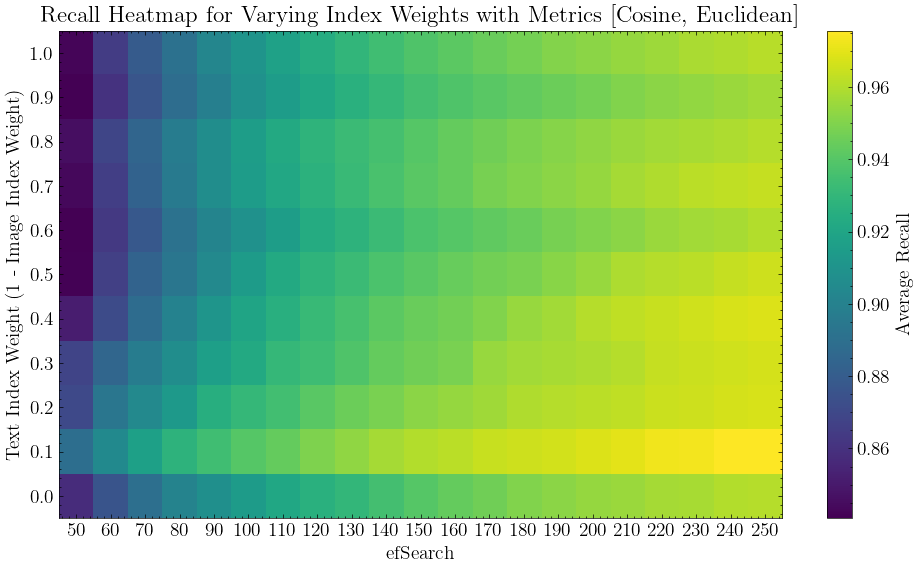

In [13]:
metrics = ["cosine", "euclidean"]
recall_data, k = get_recall_at_indexweights_data(metrics, construction_params, search_weights_exps_folder)
plot_heatmap_for_index_weights_recall_data(metrics, construction_params, recall_data, max_ef=250, plot_by_image_weight=False)

In [155]:
len(recall_data[0.3][50][0])

1000

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
initial length: 1
[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
weight 0.0 has 100 items
weight 0.1 has 100 items
weight 0.2 has 100 items
weight 0.3 has 100 items
weight 0.4 has 100 items
weight 0.5 has 100 items
weight 0.6 has 100 items
weight 0.7 has 100 items
weight 0.8 has 100 items
weight 0.9 has 100 items
weight 1.0 has 100 items


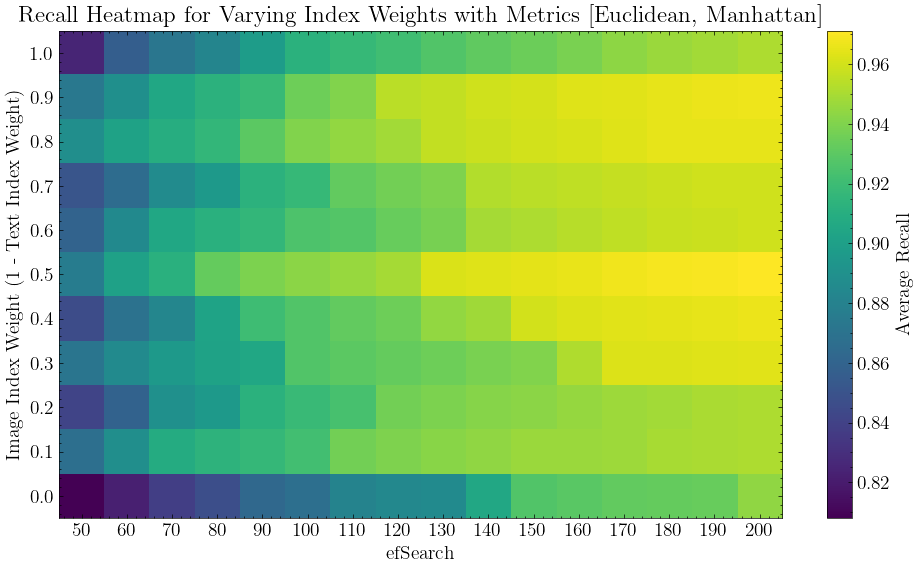

In [40]:
metrics = ["euclidean", "manhattan"]
recall_data, k = get_recall_at_indexweights_data(metrics, construction_params, search_weights_exps_folder)
plot_heatmap_for_index_weights_recall_data(metrics, construction_params, recall_data, max_ef=200)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
initial length: 1
[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
weight 0.0 has 1000 items
weight 0.1 has 1000 items
weight 0.2 has 1000 items
weight 0.3 has 1000 items
weight 0.4 has 1000 items
weight 0.5 has 1000 items
weight 0.6 has 1000 items
weight 0.7 has 1000 items
weight 0.8 has 1000 items
weight 0.9 has 1000 items
weight 1.0 has 1000 items


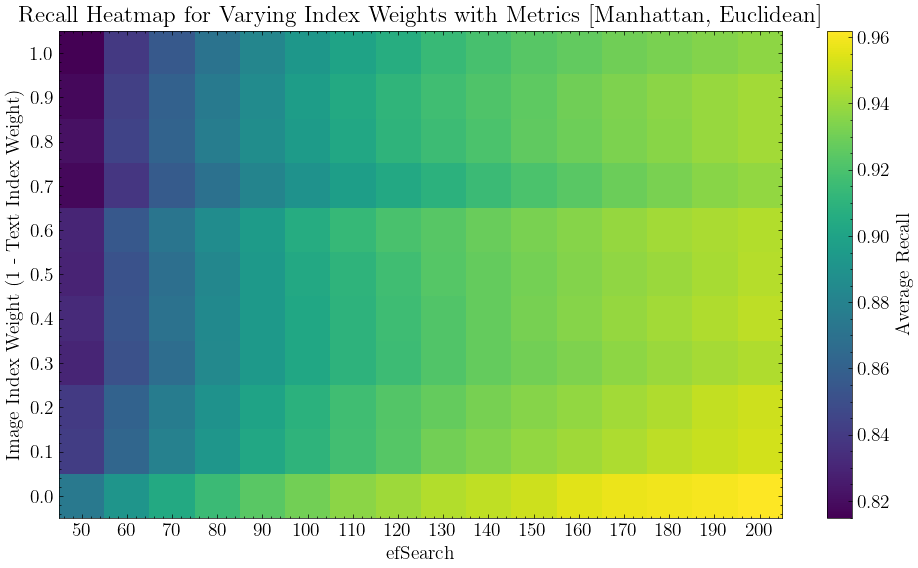

In [41]:
metrics = ["manhattan", "euclidean"]
recall_data, k = get_recall_at_indexweights_data(metrics, construction_params, search_weights_exps_folder)
plot_heatmap_for_index_weights_recall_data(metrics, construction_params, recall_data, max_ef=200)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
initial length: 1
[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
weight 0.0 has 1000 items
weight 0.1 has 1000 items
weight 0.2 has 1000 items
weight 0.3 has 1000 items
weight 0.4 has 1000 items
weight 0.5 has 1000 items
weight 0.6 has 1000 items
weight 0.7 has 1000 items
weight 0.8 has 1000 items
weight 0.9 has 1000 items
weight 1.0 has 1000 items


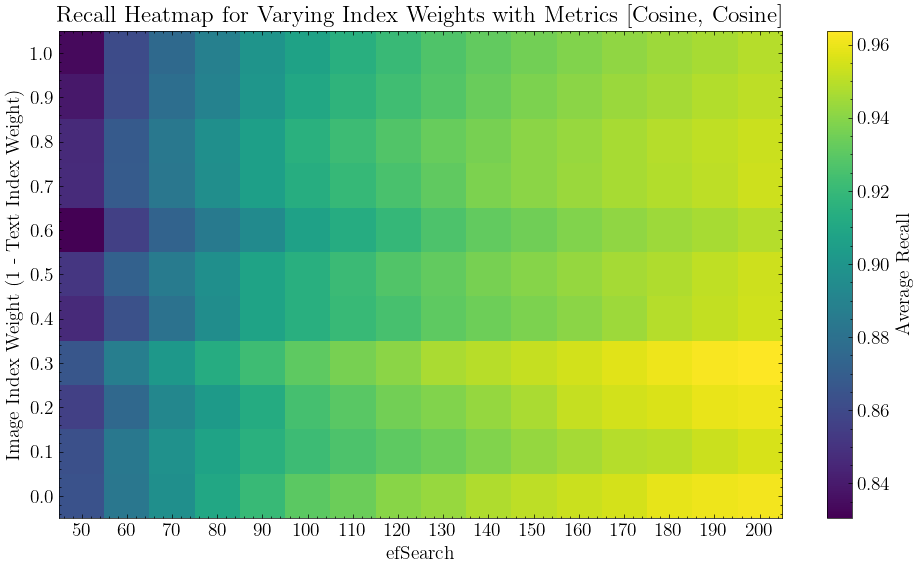

In [43]:
construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=50)
metrics = ["cosine", "cosine"]
recall_data, k = get_recall_at_indexweights_data(metrics, construction_params, search_weights_exps_folder, normalised="")
plot_heatmap_for_index_weights_recall_data(metrics, construction_params, recall_data, max_ef=200)